The highlights of this notebooks:
* Refresher on attempting application of Pytorch on text dataset using different methods to prep data
* Application of self embedding model as well as LSTM for basic classification and some other basic classifiers
* Application of pre-trained embedding model (GloVe) for classification using LSTM


In [1]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_pytorch_nlp


In [2]:
import torch
import torchtext
import os
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import ngrams_iterator

 We will start with classification

In [3]:
os.makedirs("./data", exist_ok=True)
train_dataset, test_dataset = torchtext.datasets.AG_NEWS(root="./data")
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

In [4]:
label, text = next(iter(train_dataset))
print(text)
print(label)

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
3


In [5]:
for i, x in zip(range(5), train_dataset):
    print(f"**{target_classes[x[0]]}** -> {x[1]}\n")

**Sci/Tech** -> Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

**Sci/Tech** -> Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.

**Sci/Tech** -> Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.

**Sci/Tech** -> Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.

**Sci/Tech** -> Oil prices soa

/home/azureuser/.local/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [6]:
# ech list contains a tuple of label and text
train_dataset = list(train_dataset)
test_dataset = list(test_dataset)

The first step is to convert text to tokens — tokenization

In [7]:
tokenizer = get_tokenizer("basic_english")

In [8]:
tokenizer(train_dataset[0][-1])

['wall',
 'st',
 '.',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'short-sellers',
 ',',
 'wall',
 'street',
 "'",
 's',
 'dwindling\\band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.']

Vectorization using vocabulary

In [9]:
# counter to measure frequency
Counter(tokenizer(train_dataset[0][-1]))

Counter({'wall': 2,
         'st': 1,
         '.': 2,
         'bears': 1,
         'claw': 1,
         'back': 1,
         'into': 1,
         'the': 1,
         'black': 1,
         '(': 1,
         'reuters': 2,
         ')': 1,
         '-': 1,
         'short-sellers': 1,
         ',': 2,
         'street': 1,
         "'": 1,
         's': 1,
         'dwindling\\band': 1,
         'of': 1,
         'ultra-cynics': 1,
         'are': 1,
         'seeing': 1,
         'green': 1,
         'again': 1})

In [10]:
unk_token = "<unk>"
default_index = -1

Directly using an orderdict and vocab class

In [11]:
counter_token = Counter()
for label, line in train_dataset:
    counter_token.update(tokenizer(line))

In [12]:
vocabulary = torchtext.vocab.vocab(
    counter_token, min_freq=1, specials=[unk_token])
vocabulary.set_default_index(default_index)

In [13]:
print(vocabulary["<unk>"])  # prints 0
print(vocabulary["out of vocab"])  # prints -1

0
-1


Another way is using an iterator and using build_vocab_from_iterator

In [14]:
# def build_vocab_iter(datasets):
#     """yields tokenized text"""
#     for dataset in datasets:
#         for _, text in dataset:
#             yield tokenizer(text)


# vocabulary = build_vocab_from_iterator(
#     build_vocab_iter([train_dataset, test_dataset]), specials=[unk_token]
# )  # build vocab from an iterator
# # anything unk will be have a default index
# vocabulary.set_default_index(default_index)

In [15]:
# print(vocabulary["<unk>"])  # prints 0
# print(vocabulary["out of vocab"])  # prints -1

In [16]:
# This vocabulary maps words to indices present in the num corpus

print([(vocabulary[token], token) for token in tokenizer(train_dataset[-1][-1])])

[(7837, 'nets'), (893, 'get'), (6108, 'carter'), (79, 'from'), (14070, 'raptors'), (13624, 'indianapolis'), (339, '--'), (8386, 'all-star'), (45003, 'vince'), (6108, 'carter'), (223, 'was'), (9132, 'traded'), (153, 'by'), (8, 'the'), (6504, 'toronto'), (14070, 'raptors'), (98, 'to'), (8, 'the'), (102, 'new'), (5489, 'jersey'), (7837, 'nets'), (39, 'for'), (34010, 'alonzo'), (26167, 'mourning'), (15, ','), (4421, 'eric'), (6105, 'williams'), (15, ','), (10829, 'aaron'), (6105, 'williams'), (15, ','), (42, 'and'), (37, 'a'), (1740, 'pair'), (20, 'of'), (7644, 'first-round'), (7645, 'draft'), (7751, 'picks'), (617, 'yesterday'), (3, '.')]


In [17]:
vocab_size = len(vocabulary)
print(f"Vocab size if {vocab_size}")

Vocab size if 95811


In [18]:
vocabulary(["Maya"])

[-1]

In [19]:
# Create and encoder and decoder function for word to index and reverse
def encoder(x):
    """from string to integers"""
    return vocabulary(tokenizer(x))


def decoder(x):
    """from integers to string"""
    return [vocabulary.get_itos()[index] for index in x]

In [20]:
vec = encoder(train_dataset[0][-1])

In [21]:
" ".join(decoder(vec))

"wall st . bears claw back into the black ( reuters ) reuters - short-sellers , wall street ' s dwindling\\band of ultra-cynics , are seeing green again ."

Tokenization misses out on BiGrams, TriGrams and N-Grams

In [22]:
# first tokenize 1v1 and then 2 adjacent words together
list(ngrams_iterator(tokenizer(train_dataset[0][-1]), 2))

['wall',
 'st',
 '.',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'short-sellers',
 ',',
 'wall',
 'street',
 "'",
 's',
 'dwindling\\band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.',
 'wall st',
 'st .',
 '. bears',
 'bears claw',
 'claw back',
 'back into',
 'into the',
 'the black',
 'black (',
 '( reuters',
 'reuters )',
 ') reuters',
 'reuters -',
 '- short-sellers',
 'short-sellers ,',
 ', wall',
 'wall street',
 "street '",
 "' s",
 's dwindling\\band',
 'dwindling\\band of',
 'of ultra-cynics',
 'ultra-cynics ,',
 ', are',
 'are seeing',
 'seeing green',
 'green again',
 'again .']

In [23]:
bi_counter_token = Counter()
for label, line in train_dataset:
    bi_counter_token.update(ngrams_iterator(tokenizer(line), 2))

bi_vocabulary = torchtext.vocab.vocab(
    bi_counter_token, min_freq=2, specials=[unk_token]
)
bi_vocabulary.set_default_index(default_index)

In [24]:
bi_vocab_size = len(bi_vocabulary)
print(f"Vocab size if {bi_vocab_size}")

Vocab size if 481970


As ngrams leads to more words we will stick to unigrams

we’ll explore some of the approaches to feeding variable-length text into a neural network to collapse the input sequence into a fixed-length vector, which can then be used in the classifier.

BoW vector: Traditional representation where words are indexed, and vector elements count word occurrences in a document or sum one-hot-encoded vectors.

In [25]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# Create a set of stop words
stop_words = set(stopwords.words("english"))


# Define a function to remove stop words from a sentence
def remove_stop_words(sentence):
    # Split the sentence into individual words
    words = sentence.split(" ")

    # Use a list comprehension to remove stop words
    filtered_words = [word for word in words if word not in stop_words]

    # Join the filtered words back into a sentence
    return " ".join(filtered_words)

In [27]:
def to_bow(text, vocab_size):
    result_vector = torch.zeros(vocab_size, dtype=torch.float32)
    text = remove_stop_words(text)
    for i in encoder(text):
        if i < vocab_size:
            result_vector[i] += 1
    return result_vector

In [28]:
bow_vector = to_bow(train_dataset[0][-1], vocab_size)

In [29]:
len(bow_vector)  # sparse vector

95811

BOW classifier

In [30]:
import torch.nn as nn
from torch.utils.data import DataLoader
import re
from torchsummary import summary
from torchview import draw_graph
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from src.pytorch_helpers import *

In [31]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 10
epochs = 10
lr = 1e-3

Random seed set as 42
cuda


In [32]:
def vectorize_batch(batch):
    """Vectorize the batch"""
    return (
        torch.stack([to_bow(t[1], vocab_size) for t in batch])
        .type(torch.float32)
        .to(device),
        torch.tensor([t[0] - 1 for t in batch], dtype=torch.int64).to(device),
    )

In [33]:
# As bow is very slow we will do it only for 1000 entries
sub_train_dataset = train_dataset[: batch_size * 100]
sub_test_dataset = test_dataset[: batch_size * 100]

In [34]:
train_loader = DataLoader(
    sub_train_dataset, batch_size=batch_size, collate_fn=vectorize_batch
)
test_loader = DataLoader(
    sub_test_dataset, batch_size=batch_size, collate_fn=vectorize_batch
)

In [35]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([10, 95811]) torch.Size([10])


In [36]:
class BasicBOWClassifier(nn.Module):
    """Basic Bow Classifier"""

    def __init__(self, num_classes):
        super(BasicBOWClassifier, self).__init__()

        self.fn_layer = nn.Sequential(
            nn.Linear(vocab_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        return self.fn_layer(x)

In [37]:
basic_classifier = BasicBOWClassifier(4).to(device)
print(basic_classifier)
summary(basic_classifier, input_size=[(batch_size, vocab_size)],)

BasicBOWClassifier(
  (fn_layer): Sequential(
    (0): Linear(in_features=95811, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 10, 128]      12,263,936
              ReLU-2              [-1, 10, 128]               0
            Linear-3               [-1, 10, 64]           8,256
              ReLU-4               [-1, 10, 64]               0
            Linear-5                [-1, 10, 4]             260
Total params: 12,272,452
Trainable params: 12,272,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.65
Forward/backward pass size (MB): 0.03
Params size (MB): 46.82
Estimated Total Size (MB): 50.50
-----------------------

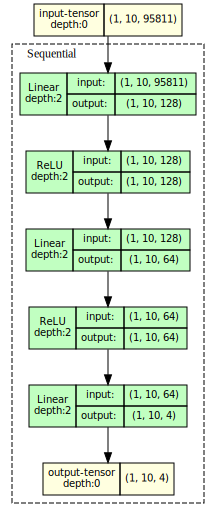

In [38]:
# graphical representation of the model architecture
model_graph = draw_graph(
    basic_classifier, input_size=(1, batch_size, vocab_size), expand_nested=True
)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [39]:
# driver setup
optimizer = optim.Adam(basic_classifier.parameters(), lr=lr, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
metric = MulticlassAccuracy(device=device, num_classes=4)

In [40]:
# Place holders----
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        basic_classifier,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        basic_classifier,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )

Epoch 0


Avg Train Loss: 1.4532230861485005 Avg Train Metric: 0.4436385416984558: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.16it/s]


Epoch 1


Avg Train Loss: 1.0328660479560494 Avg Train Metric: 0.6085626663267613: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 53.21it/s]


Epoch 2


Avg Train Loss: 0.6984906765446067 Avg Train Metric: 0.6459793493151664: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.47it/s]


Epoch 3


Avg Train Loss: 0.3798114733304828 Avg Train Metric: 0.8597654730081559: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.83it/s]


Epoch 4


Avg Train Loss: 0.16807423015590758 Avg Train Metric: 0.9810120224952698: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.51it/s]


Epoch 5


Avg Train Loss: 0.07236678245535585 Avg Train Metric: 0.9963009619712829: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.55it/s]


Epoch 6


Avg Train Loss: 0.04150171425077133 Avg Train Metric: 0.9864485073089599: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.07it/s]


Epoch 7


Avg Train Loss: 0.02647149136148073 Avg Train Metric: 0.9981787127256393: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.27it/s]


Epoch 8


Avg Train Loss: 0.02194462392522837 Avg Train Metric: 0.9980739051103592: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.35it/s]


Epoch 9


Avg Train Loss: 0.019895044419681655 Avg Train Metric: 0.99808489382267: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 55.85it/s]


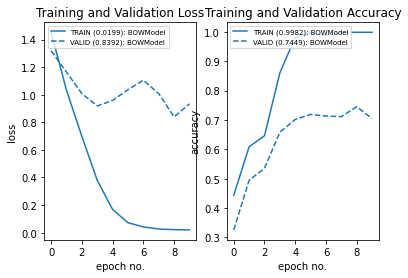

In [41]:
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["BOWModel"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

In [42]:
Y_actual, Y_preds = MakePredictions(basic_classifier, test_loader)
print(Y_actual.shape)
print(Y_preds.shape)

(1000,)
(1000,)


In [43]:
print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.694

Classification Report : 
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       268
           1       0.94      0.62      0.74       274
           2       0.70      0.45      0.55       205
           3       0.59      0.86      0.70       253

    accuracy                           0.69      1000
   macro avg       0.73      0.68      0.68      1000
weighted avg       0.73      0.69      0.69      1000


Confusion Matrix : 
[[215   8  16  29]
 [ 59 169   8  38]
 [ 27   2  93  83]
 [ 20   1  15 217]]
